# Analysis of *Aribidopis*, maize and sorghum promoter STARR-seq data from Jores et al. (2021)
<img src="images/jores21.png" width=1000, height=500>

Jores T, *et al*. 2021. Synthetic promoter designs enabled by a comprehensive analysis of plant core promoters. Nat Plants 7:842–855. doi:10.1038/s41477-021-00932-y

In [1]:
# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload 
%autoreload 2

# Python imports for analysis
import numpy as np
import pandas as pd
import eugene as eu

# Configure EUGENe 
print(eu.__version__)
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene"
eu.settings.logging_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/jores21"
eu.settings.output_dir = "/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21"
eu.settings.dl_num_workers = 4
eu.settings.batch_size = 128

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000
0.1.0


# Dataloading

In [227]:
# Load the dataset from the module
sdata_leaf = eu.datasets.jores21("leaf")
sdata_proto = eu.datasets.jores21("proto")
sdata_leaf, sdata_proto

Dataset jores21 CNN_test_leaf.tsv has already been dowloaded.
Dataset jores21 CNN_train_leaf.tsv has already been dowloaded.
Dataset jores21 CNN_train_proto.tsv has already been dowloaded.
Dataset jores21 CNN_test_proto.tsv has already been dowloaded.


(SeqData object with = 72158 seqs
 seqs = (72158,)
 names = (72158,)
 rev_seqs = None
 ohe_seqs = None
 ohe_rev_seqs = None
 seqs_annot: 'set', 'sp', 'gene', 'enrichment'
 pos_annot: None
 seqsm: None
 uns: None,
 SeqData object with = 75808 seqs
 seqs = (75808,)
 names = (75808,)
 rev_seqs = None
 ohe_seqs = None
 ohe_rev_seqs = None
 seqs_annot: 'set', 'sp', 'gene', 'enrichment'
 pos_annot: None
 seqsm: None
 uns: None)

In [50]:
# Load some other sequence features
smetadata = pd.read_excel(
    "/cellar/users/aklie/data/eugene/jores21/41477_2021_932_MOESM3_ESM.xlsx", 
    sheet_name=0, 
    skiprows=3, 
)
len(smetadata), \
smetadata["sequence"].isin(sdata_leaf.seqs).sum(), \
smetadata["sequence"].isin(sdata_proto.seqs).sum()

(79838, 72144, 75792)

In [51]:
# Add them to seqs_annot, eventually turn this into a function
sdata_leaf["sequence"] = sdata_leaf.seqs
sdata_proto["sequence"] = sdata_proto.seqs
sdata_leaf.seqs_annot = sdata_leaf.seqs_annot.merge(smetadata, on="sequence", how="left")
sdata_proto.seqs_annot = sdata_proto.seqs_annot.merge(smetadata, on="sequence", how="left")

In [52]:
# More metadata that could serve as targets as well, we will leave this out for now
stargets = pd.read_excel(
    "/cellar/users/aklie/data/eugene/jores21/41477_2021_932_MOESM3_ESM.xlsx", 
    sheet_name=1, 
    skiprows=3, 
)

# Data Visualization

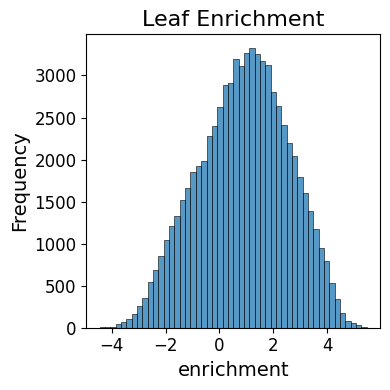

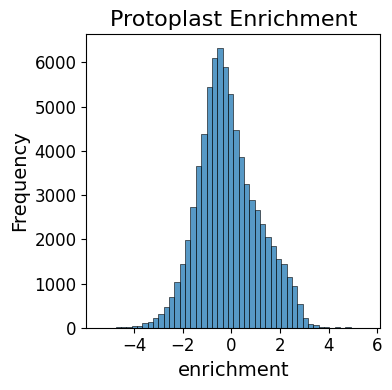

In [53]:
eu.pl.histplot(
    sdata_leaf, 
    keys="enrichment",
    orient="h",
    bins=50,
    title="Leaf Enrichment"
)
eu.pl.histplot(
    sdata_proto, 
    keys="enrichment",
    orient="h",
    bins=50,
    title="Protoplast Enrichment"
)

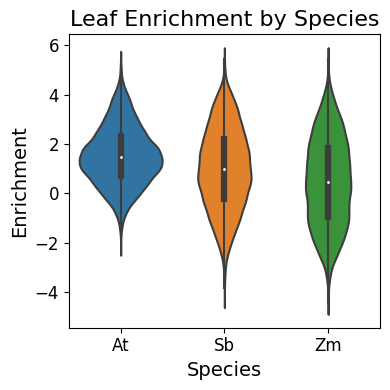

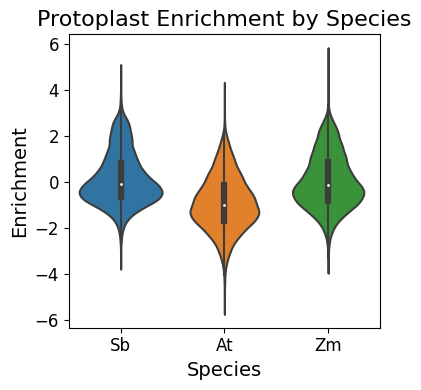

In [193]:
eu.pl.violinplot(
    sdata_leaf, 
    keys="enrichment", 
    groupby="sp",
    xlab="Species",
    ylab="Enrichment",
    title="Leaf Enrichment by Species",
    save="/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/leaf_enrichment_by_species.png"
)
eu.pl.violinplot(
    sdata_proto, 
    keys="enrichment", 
    groupby="sp",
    xlab="Species",
    ylab="Enrichment",
    title="Protoplast Enrichment by Species",
    save="/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/proto_enrichment_by_species.png"
)

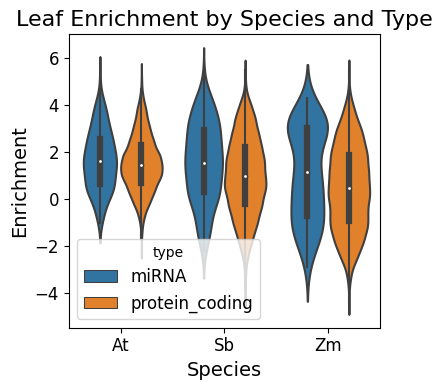

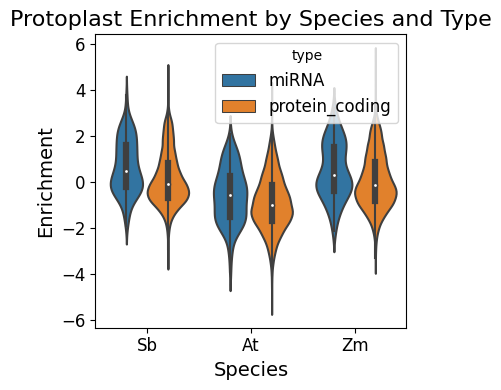

In [70]:
eu.pl.violinplot(
    sdata_leaf,
    keys="enrichment",
    groupby="sp",
    hue="type",
    xlab="Species",
    ylab="Enrichment",
    title="Leaf Enrichment by Species and Type",
    save="/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/leaf_enrichment_by_species_and_type.png"
)
eu.pl.violinplot(
    sdata_proto, 
    keys="enrichment", 
    groupby="sp",
    hue="type",
    xlab="Species",
    ylab="Enrichment",
    title="Protoplast Enrichment by Species and Type",
    save="/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/proto_enrichment_by_species_and_type.png"
)

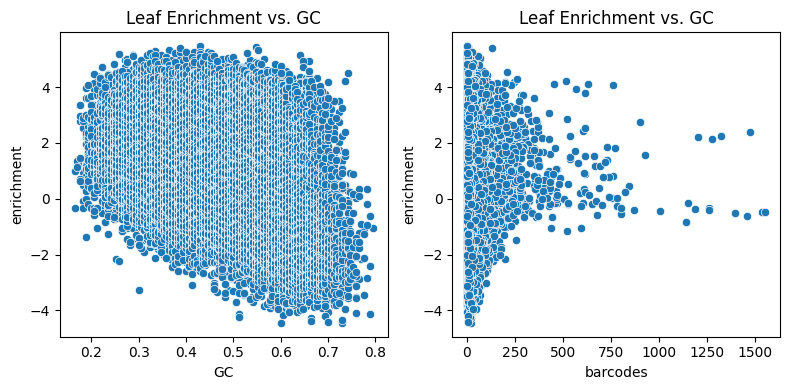

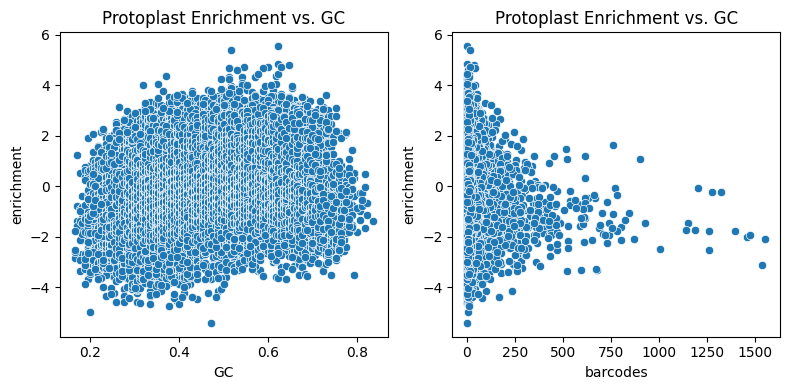

In [71]:
eu.pl.scatterplot(
    sdata_leaf,
    x=["GC", "barcodes"],
    y="enrichment",
    orient="h",
    title="Leaf Enrichment vs. GC",
    save="/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/leaf_enrichment_vs_GC.png"
)
eu.pl.scatterplot(
    sdata_proto,
    x=["GC", "barcodes"],
    y="enrichment",
    orient="h",
    title="Protoplast Enrichment vs. GC",
    save="/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/proto_enrichment_vs_GC.png"
)

# Preprocessing

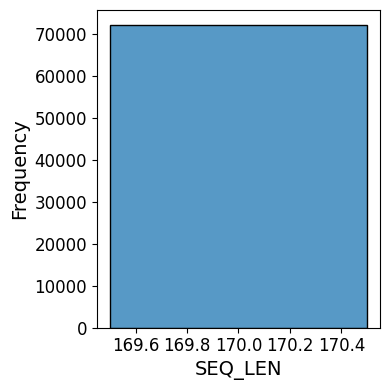

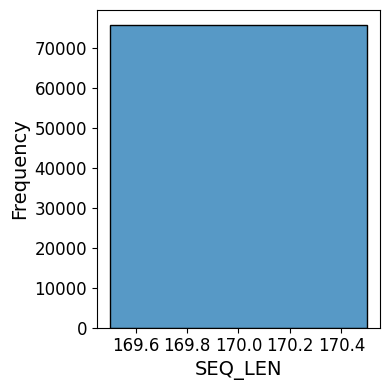

In [73]:
# Get and plot the distrubution on sequence length 
sdata_leaf["SEQ_LEN"] = [len(seq) for seq in sdata_leaf.seqs]
eu.pl.histplot(sdata_leaf, keys="SEQ_LEN", orient="h")

# Get and plot the distrubution on sequence length
sdata_proto["SEQ_LEN"] = [len(seq) for seq in sdata_proto.seqs]
eu.pl.histplot(sdata_proto, keys="SEQ_LEN", orient="h")

In [74]:
# One hot encode all the sequences
eu.pp.one_hot_encode_data(sdata_leaf)
eu.pp.one_hot_encode_data(sdata_proto)

SeqData object modified:
	ohe_seqs: None -> 72158 ohe_seqs added
SeqData object modified:
	ohe_seqs: None -> 75808 ohe_seqs added


In [75]:
# Check the labels
sdata_leaf["set"].value_counts(), sdata_proto["set"].value_counts()

(train    65004
 test      7154
 Name: set, dtype: int64,
 train    68213
 test      7595
 Name: set, dtype: int64)

In [76]:
# Split into training and dest
sdata_leaf_train = sdata_leaf[sdata_leaf["set"] == "train"]
sdata_leaf_test = sdata_leaf[sdata_leaf["set"] == "test"]

sdata_proto_train = sdata_proto[sdata_proto["set"] == "train"]
sdata_proto_test = sdata_proto[sdata_proto["set"] == "test"]

In [ ]:
# Need to fix this
sdata_leaf_train.seqs_annot.index = sdata_leaf_train.names

In [77]:
# Split training into train and val
eu.pp.train_test_split_data(sdata_leaf_train, split=0.9)
eu.pp.train_test_split_data(sdata_proto_train, split=0.9)

SeqData object modified:
    seqs_annot:
        + train
SeqData object modified:
    seqs_annot:
        + train


In [80]:
# Double check the train and val split
sdata_leaf_train["train"].value_counts(), sdata_proto_train["train"].value_counts()

(True     58503
 False     6501
 Name: train, dtype: int64,
 True     61391
 False     6822
 Name: train, dtype: int64)

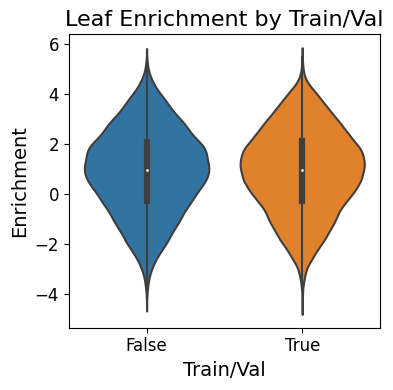

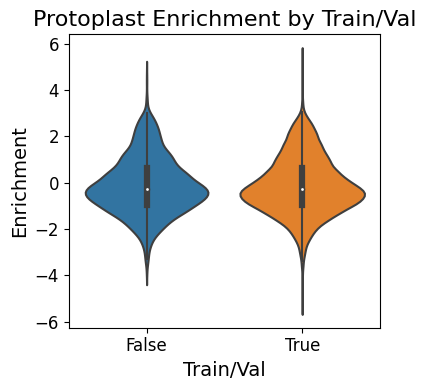

In [82]:
# Double check for a random split
eu.pl.violinplot(
    sdata_leaf_train, 
    keys="enrichment", 
    groupby="train",
    xlab="Train/Val",
    ylab="Enrichment",
    title="Leaf Enrichment by Train/Val",
    save="/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/leaf_enrichment_by_train_val.png"
)
eu.pl.violinplot(
    sdata_proto_train, 
    keys="enrichment", 
    groupby="train",
    xlab="Train/Val",
    ylab="Enrichment",
    title="Protoplast Enrichment by Train/Val",
    save="/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/proto_enrichment_by_train_val.png")


# Training

In [90]:
# Instantiate two Jores21CNNs
model_leaf = eu.models.Jores21CNN(
    input_len=170,
    output_dim=1,
    layers=3,
    filters=256,
    dropout=0.3,
    scheduler = "reduce_lr_on_plateau",
    scheduler_patience=2,
    lr=0.001
)
model_proto = eu.models.Jores21CNN(
    input_len=170,
    output_dim=1,
    layers=3,
    filters=256,
    dropout=0.3,
    scheduler = "reduce_lr_on_plateau",
    scheduler_patience=2,
    lr=0.001
)

In [91]:
# Print out the model summaries
model_leaf.summary(), model_proto.summary()

Model: Jores21CNN
Input length: 170
Output dimension: 1
Strand: ss
Task: regression
Aggregation: None
Loss function: mse_loss
Optimizer: adam
Learning rate: 0.001
Scheduler: reduce_lr_on_plateau
Scheduler patience: 2
Model: Jores21CNN
Input length: 170
Output dimension: 1
Strand: ss
Task: regression
Aggregation: None
Loss function: mse_loss
Optimizer: adam
Learning rate: 0.001
Scheduler: reduce_lr_on_plateau
Scheduler patience: 2


(  | Name      | Type        | Params
 ------------------------------------------
 0 | hp_metric | R2Score     | 0     
 1 | biconv    | BiConv1D    | 1.7 M 
 2 | conv      | Conv1d      | 852 K 
 3 | dropout   | Dropout     | 0     
 4 | fc        | Linear      | 2.8 M 
 5 | batchnorm | BatchNorm1d | 128   
 6 | fc2       | Linear      | 65    
 ------------------------------------------
 5.4 M     Trainable params
 0         Non-trainable params
 5.4 M     Total params
 21.423    Total estimated model params size (MB),
   | Name      | Type        | Params
 ------------------------------------------
 0 | hp_metric | R2Score     | 0     
 1 | biconv    | BiConv1D    | 1.7 M 
 2 | conv      | Conv1d      | 852 K 
 3 | dropout   | Dropout     | 0     
 4 | fc        | Linear      | 2.8 M 
 5 | batchnorm | BatchNorm1d | 128   
 6 | fc2       | Linear      | 65    
 ------------------------------------------
 5.4 M     Trainable params
 0         Non-trainable params
 5.4 M     Total para

In [92]:
# Get motifs from MEME files that will be used to initialize the first convolutional layer
core_promoter_elements = eu.utils.MinimalMEME('/cellar/users/aklie/projects/EUGENe/tests/_data/datasets/jores21/CPEs.meme')
tf_groups = eu.utils.MinimalMEME('/cellar/users/aklie/projects/EUGENe/tests/_data/datasets/jores21/TF-clusters.meme')
all_motifs = {**core_promoter_elements.motifs, **tf_groups.motifs}
len(all_motifs)

78

In [93]:
# Initialize the first 78 conv kernels with the motifs
eu.models.init_from_motifs(
    model_leaf, 
    all_motifs, 
    layer_name='biconv', 
    kernel_name='kernels',
    kernel_number=0
)
eu.models.init_from_motifs(
    model_proto, 
    all_motifs, 
    layer_name='biconv', 
    kernel_name='kernels',
    kernel_number=0
)

In [97]:
# RUN THIS ONCE THEN COMMENT FIRST TWO LINES OUT
#leaf_version = 0
#protoplast_version = 0
leaf_version, proto_version

In [94]:
# Train the leaf model
eu.train.fit(
    model=model_leaf, 
    sdata=sdata_leaf_train, 
    gpus=1, 
    target="enrichment",
    train_key="train",
    epochs=50,
    version=f"Jores21CNN_leaf_v{leaf_version}",
)
leaf_version += 1

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


No transforms given, assuming just need to tensorize).
No transforms given, assuming just need to tensorize).


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name      | Type        | Params
------------------------------------------
0 | hp_metric | R2Score     | 0     
1 | biconv    | BiConv1D    | 1.7 M 
2 | conv      | Conv1d      | 852 K 
3 | dropout   | Dropout     | 0     
4 | fc        | Linear      | 2.8 M 
5 | batchnorm | BatchNorm1d | 128   
6 | fc2       | Linear      | 65    
------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.423    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 13


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 2.515


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 1.326 >= min_delta = 0.0. New best score: 1.189


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.0. New best score: 1.159


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.089 >= min_delta = 0.0. New best score: 1.070


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 1.043


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.038


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 0.987


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.978


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.950


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.072 >= min_delta = 0.0. New best score: 0.878


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.869


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.869


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.855


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.843


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.842


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.842. Signaling Trainer to stop.


In [165]:
# Train the protoplast model
eu.train.fit(
    model=model_proto,
    sdata=sdata_proto_train,
    gpus=1,
    target="enrichment",
    train_key="train",
    epochs=50,
    version=f"Jores21CNN_proto_v{proto_version}",
)
proto_version += 1

No transforms given, assuming just need to tensorize).
No transforms given, assuming just need to tensorize).


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name      | Type        | Params
------------------------------------------
0 | hp_metric | R2Score     | 0     
1 | biconv    | BiConv1D    | 1.7 M 
2 | conv      | Conv1d      | 852 K 
3 | dropout   | Dropout     | 0     
4 | fc        | Linear      | 2.8 M 
5 | batchnorm | BatchNorm1d | 128   
6 | fc2       | Linear      | 65    
------------------------------------------
5.4 M     Trainable params
0         Non-trainable params
5.4 M     Total params
21.423    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 13


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.788


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.093 >= min_delta = 0.0. New best score: 0.695


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.073 >= min_delta = 0.0. New best score: 0.622


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.053 >= min_delta = 0.0. New best score: 0.569


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.555


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 0.519


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.519. Signaling Trainer to stop.


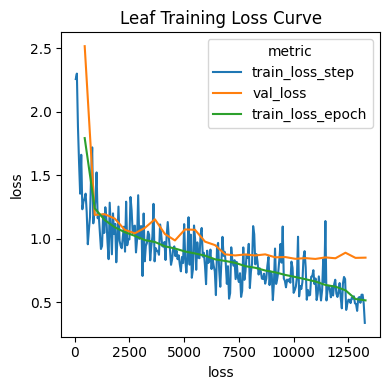

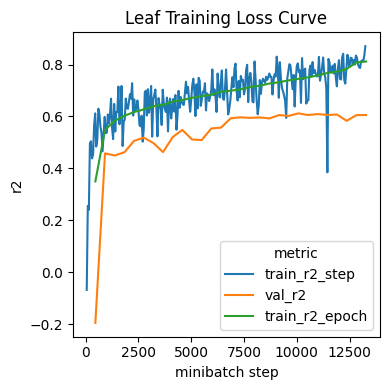

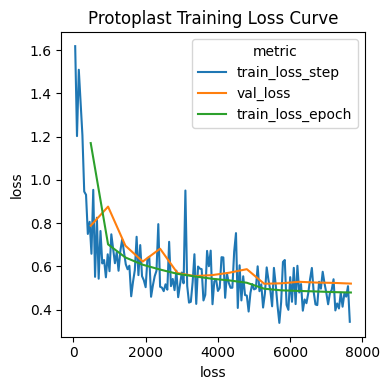

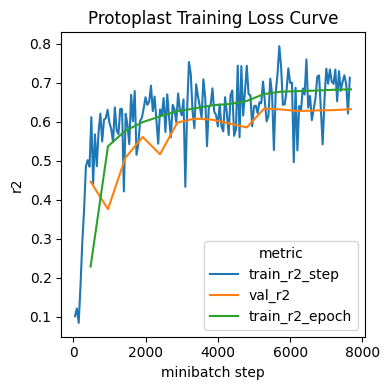

In [196]:
# Output training summary
eu.pl.training_summary(
    log_path=f"/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/jores21/ssJores21CNN_regression/Jores21CNN_leaf_v{leaf_version-1}", 
    metrics="r2",
    title="Leaf Training Loss Curve",
    save=f"/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/leaf_training_r2_curves_Jores21CNN_leaf_v{leaf_version-1}.png"
)

# Output training summary
eu.pl.training_summary(
    log_path=f"/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/jores21/ssJores21CNN_regression/Jores21CNN_proto_v{proto_version-1}", 
    metrics="r2",
    title="Protoplast Training Loss Curve",
    save=f"/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/proto_training_r2_curves_Jores21CNN_leaf_v{proto_version-1}.png"
)

# Evaluation

In [5]:
leaf_version, proto_version = 1, 1

In [6]:
# Load the best model from training
best_model_leaf = eu.models.Jores21CNN.load_from_checkpoint(f"/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/jores21/ssJores21CNN_regression/Jores21CNN_leaf_v{leaf_version-1}/checkpoints/epoch=23-step=10991.ckpt")
best_model_proto = eu.models.Jores21CNN.load_from_checkpoint(f"/cellar/users/aklie/projects/EUGENe/EUGENe_paper/logs/jores21/ssJores21CNN_regression/Jores21CNN_proto_v{proto_version-1}/checkpoints/epoch=10-step=5279.ckpt")

In [199]:
# Clean up the data -- NEED TO FIX
sdata_leaf_train.seqs_annot.index = sdata_leaf_train.names
sdata_proto_train.seqs_annot.index = sdata_proto_train.names
sdata_leaf_test.seqs_annot.index = sdata_leaf_test.names
sdata_proto_test.seqs_annot.index = sdata_proto_test.names

In [201]:
# Get train and validation predictions
eu.predict.train_val_predictions(
    best_model_leaf, 
    sdata=sdata_leaf_train, 
    target="enrichment",
    train_key="train",
    version=f"Jores21CNN_leaf_v{leaf_version-1}",
)
eu.predict.train_val_predictions(
    best_model_proto,
    sdata=sdata_proto_train,
    target="enrichment",
    train_key="train",
    version=f"Jores21CNN_proto_v{proto_version-1}",
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


No transforms given, assuming just need to tensorize).
No transforms given, assuming just need to tensorize).


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

No transforms given, assuming just need to tensorize).
No transforms given, assuming just need to tensorize).


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

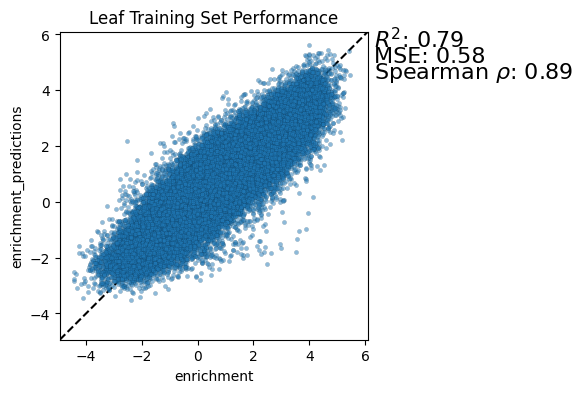

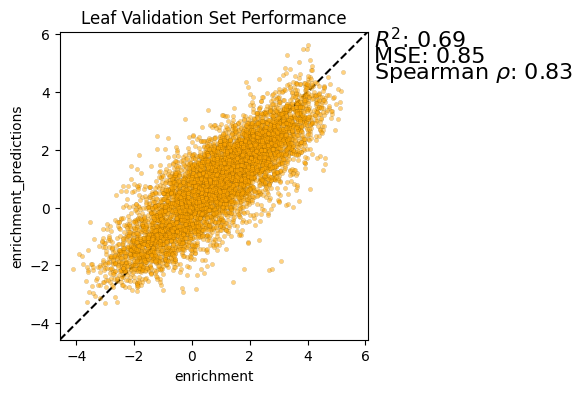

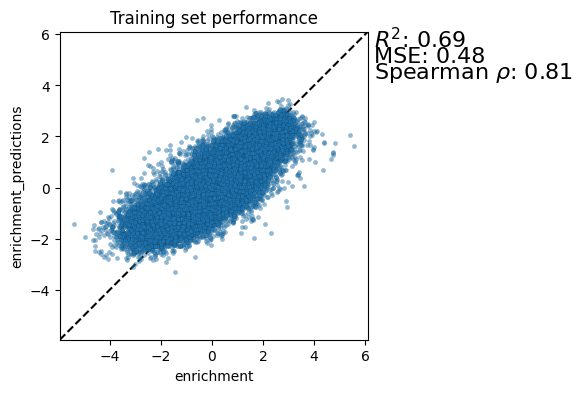

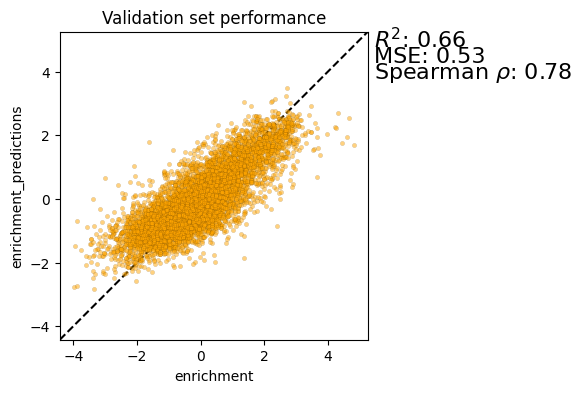

In [205]:
# Plot the performance scatterplot on the training and validation set
val_idx = np.where(sdata_leaf_train["train"] == False)[0]
train_idx = np.where(sdata_leaf_train["train"] == True)[0]
eu.pl.performance_scatter(
    sdata_leaf_train, 
    seq_idx=train_idx, 
    target="enrichment", 
    prediction="enrichment_predictions",
    title="Leaf Training Set Performance",
    alpha=0.5,
    save=f"/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/leaf_training_performance_Jores21CNN_leaf_v{leaf_version-1}.png"
)
eu.pl.performance_scatter(
    sdata_leaf_train, 
    seq_idx=val_idx, 
    target="enrichment", 
    prediction="enrichment_predictions",
    title="Leaf Validation Set Performance",
    color="orange",
    alpha=0.5,
    save=f"/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/leaf_validation_performance_Jores21CNN_leaf_v{leaf_version-1}.png"
)
val_idx = np.where(sdata_proto_train["train"] == False)[0]
train_idx = np.where(sdata_proto_train["train"] == True)[0]
eu.pl.performance_scatter(
    sdata_proto_train, 
    seq_idx=train_idx, 
    target="enrichment", 
    prediction="enrichment_predictions",
    title="Training set performance",
    alpha=0.5,
    save=f"/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/proto_training_performance_Jores21CNN_proto_v{proto_version-1}.png"
)
eu.pl.performance_scatter(
    sdata_proto_train, 
    seq_idx=val_idx, 
    target="enrichment", 
    prediction="enrichment_predictions",
    title="Validation set performance",
    color="orange",
    alpha=0.5,
    save=f"/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/proto_validation_performance_Jores21CNN_proto_v{proto_version-1}.png"
)

In [210]:
# Get test set predictions
eu.predict.predictions(
    best_model_leaf, 
    sdata=sdata_leaf_test, 
    target="enrichment",
    version=f"Jores21CNN_leaf_v{leaf_version-1}",
    file_label="test"
)
# Get test set predictions
eu.predict.predictions(
    best_model_proto, 
    sdata=sdata_proto_test, 
    target="enrichment",
    version=f"Jores21CNN_proto_v{proto_version-1}",
    file_label="test"
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).


/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:662: UserWarning: Your `predict_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  category=UserWarning,


Predicting: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


No transforms given, assuming just need to tensorize).


Predicting: 0it [00:00, ?it/s]

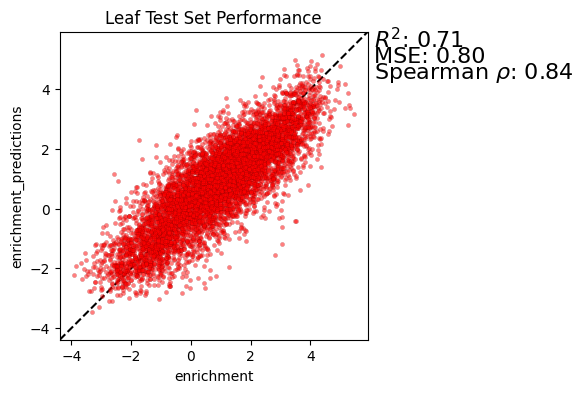

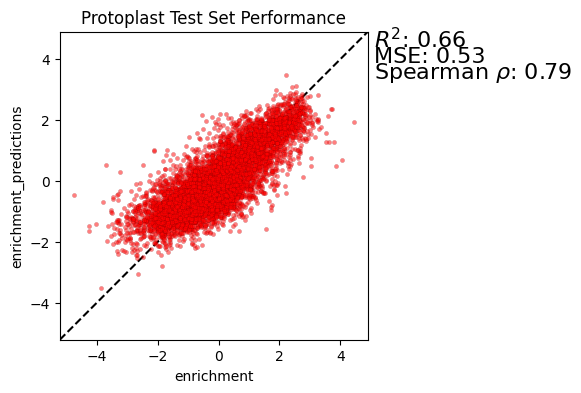

In [212]:
eu.pl.performance_scatter(
    sdata_leaf_test, 
    target="enrichment", 
    prediction="enrichment_predictions",
    title="Leaf Test Set Performance",
    color="red",
    alpha=0.5,
    save=f"/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/leaf_test_performance_Jores21CNN_leaf_v{leaf_version-1}.png"
)
eu.pl.performance_scatter(
    sdata_proto_test, 
    target="enrichment", 
    prediction="enrichment_predictions",
    title="Protoplast Test Set Performance",
    color="red",
    alpha=0.5,
    save=f"/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/proto_test_performance_Jores21CNN_proto_v{proto_version-1}.png"
)

# Interpret 

In [216]:
# Get per nucleotide feature attibutions
eu.interpret.feature_attribution(
    best_model_leaf,
    sdata_leaf_test,
    saliency_method="DeepLift",
    device= "cuda" if eu.settings.gpus > 0 else "cpu"
)

# Grab the top and bottom 10 to start
highest_10_leaf = sdata_leaf_test["enrichment_predictions"].sort_values(ascending=False).head(10).index
lowest_10_leaf = sdata_leaf_test["enrichment_predictions"].sort_values(ascending=True).head(10).index

No transforms given, assuming just need to tensorize).


Computing saliency on batches:   0%|          | 0/55 [00:00<?, ?it/s]

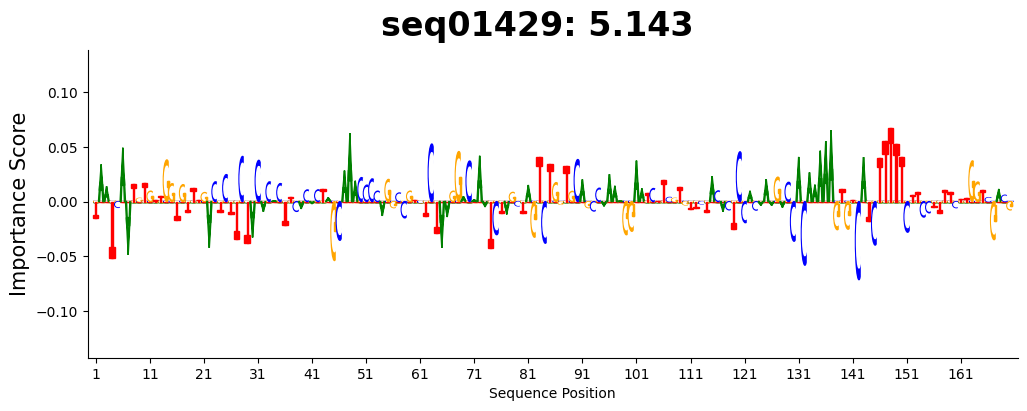

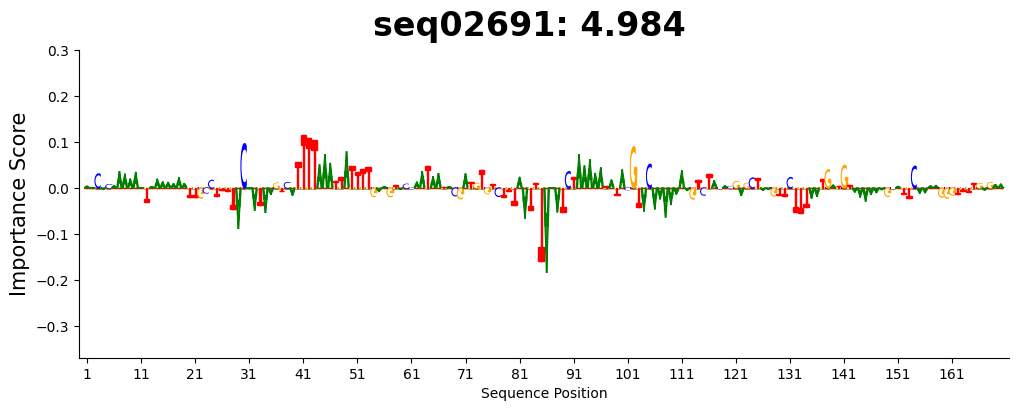

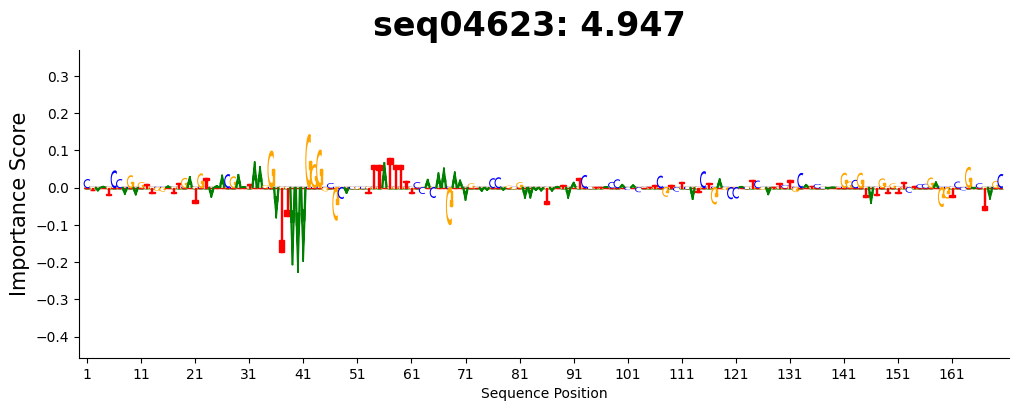

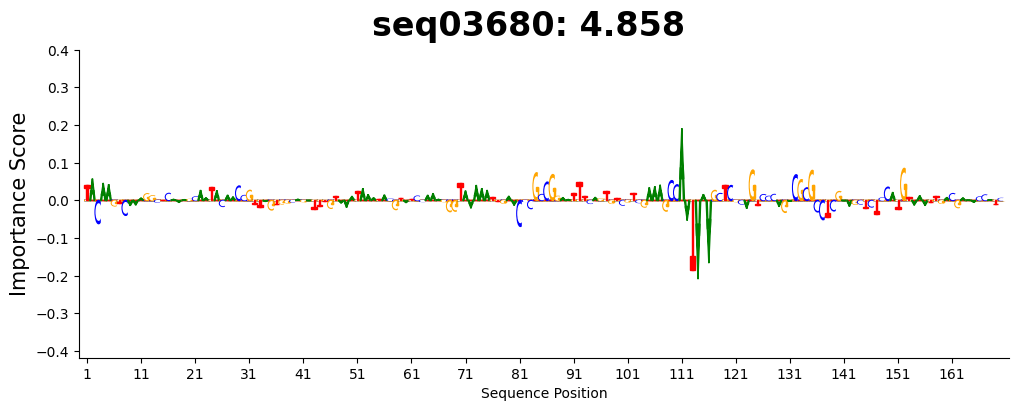

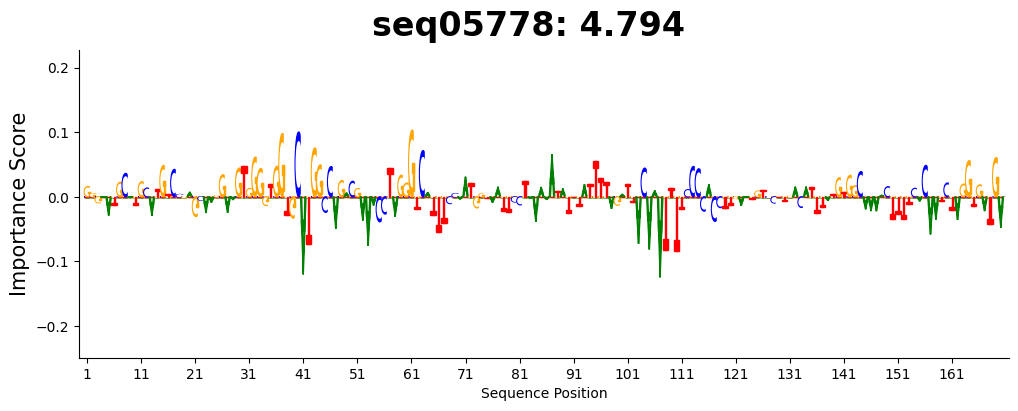

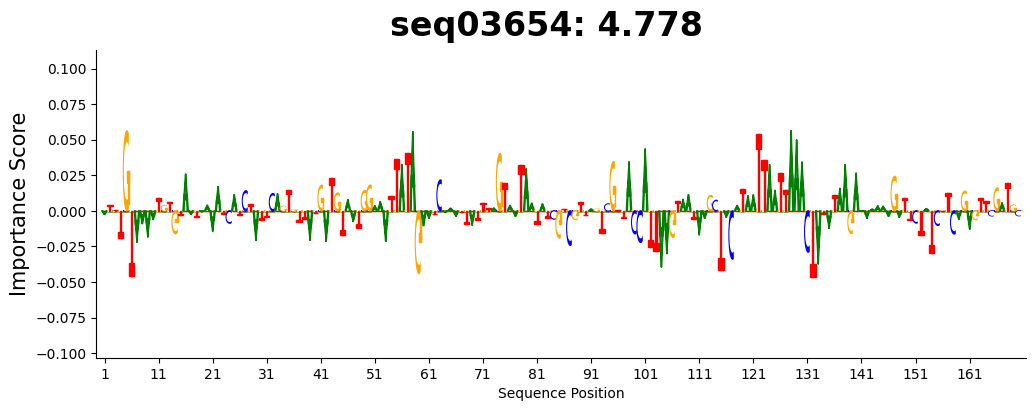

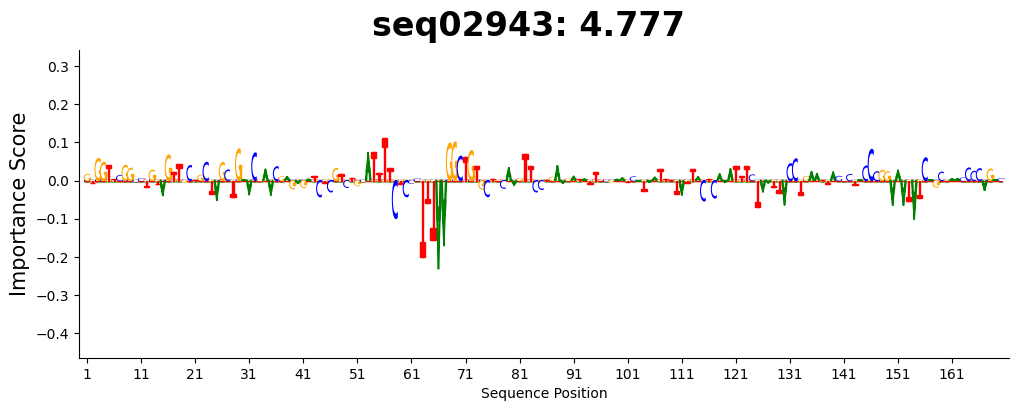

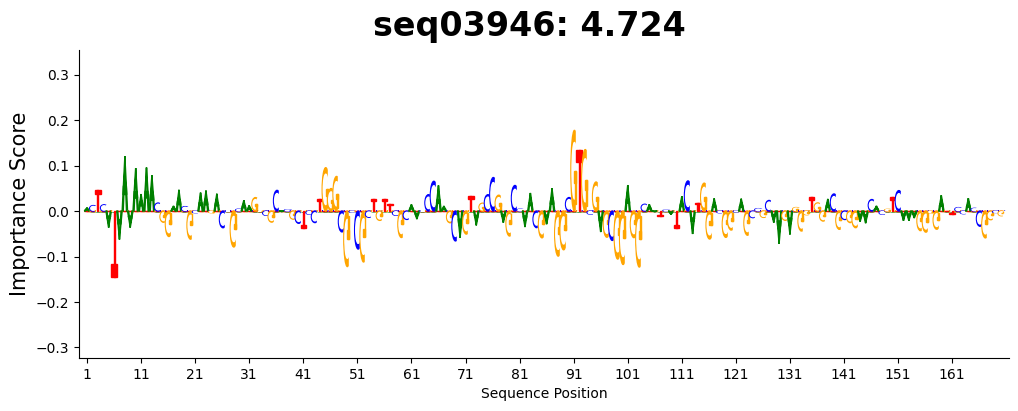

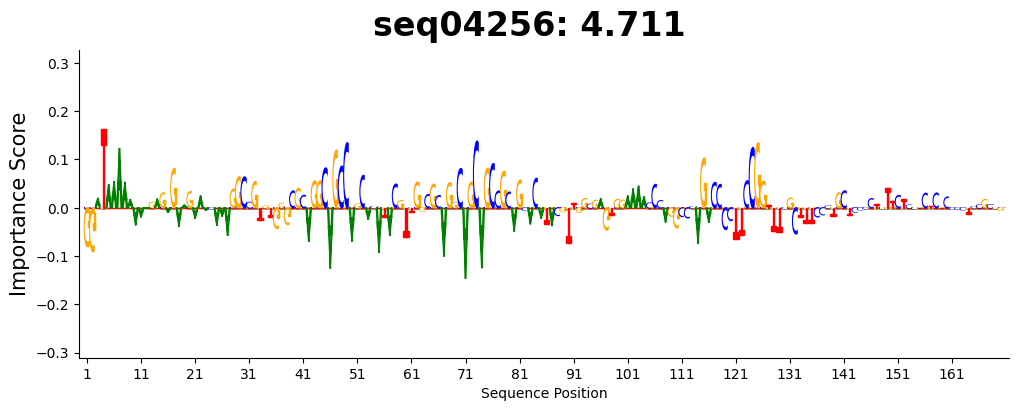

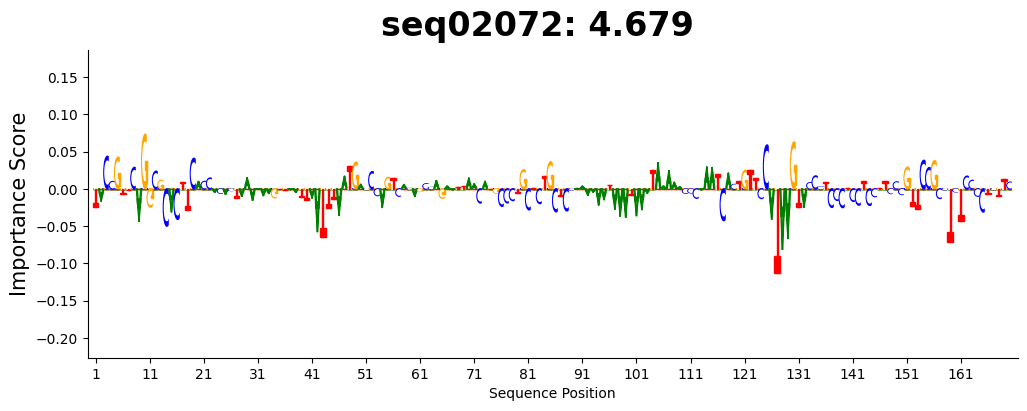

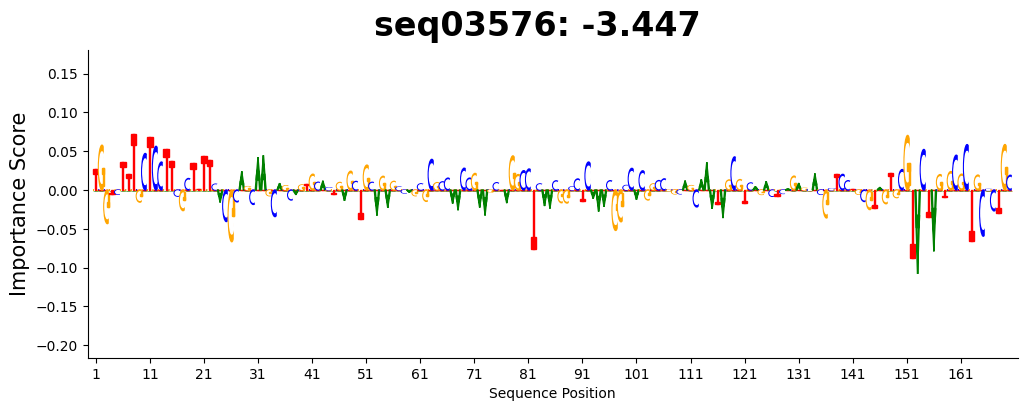

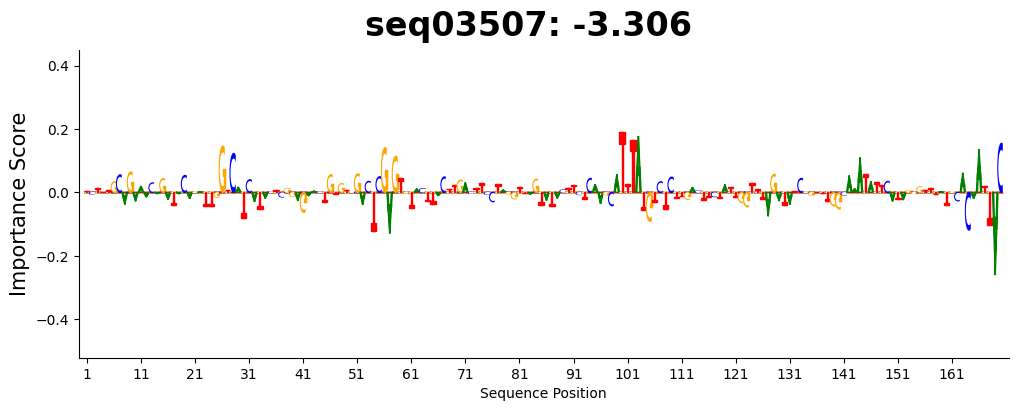

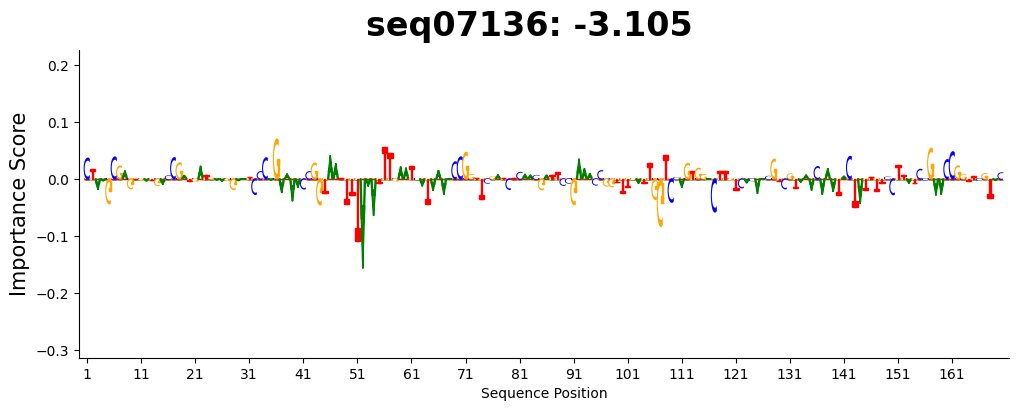

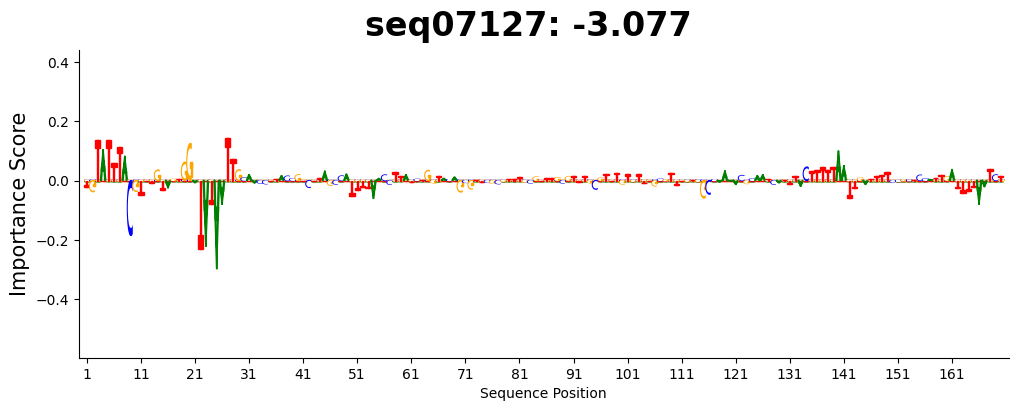

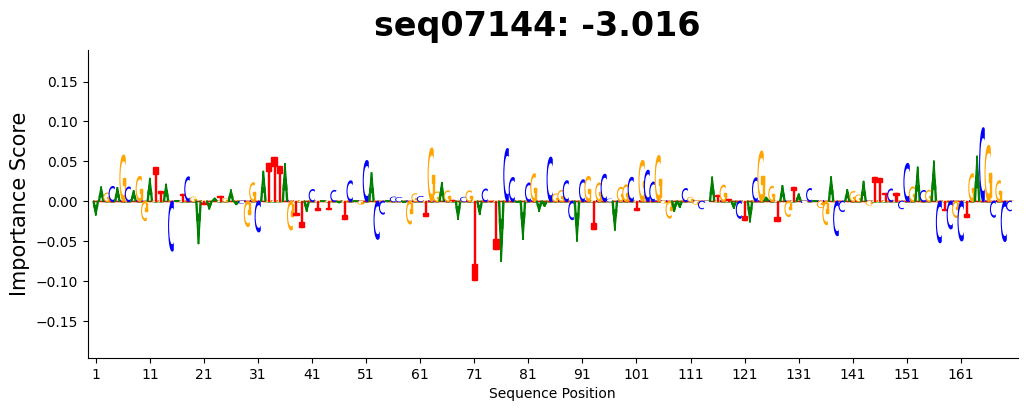

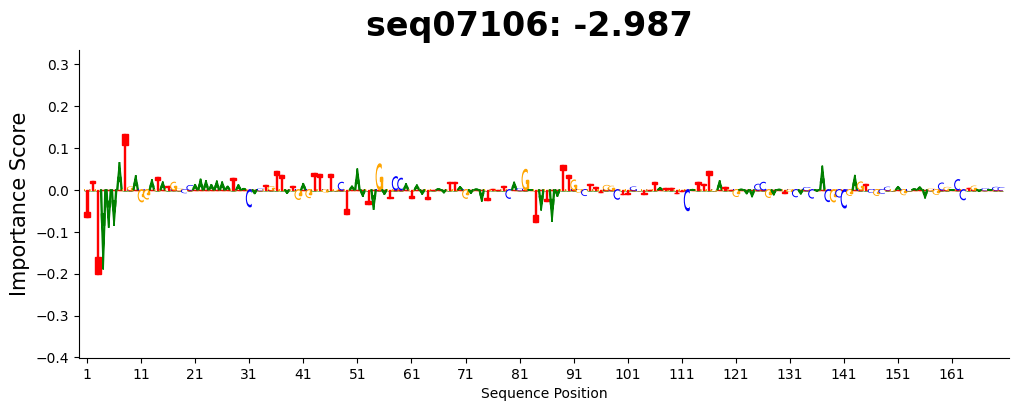

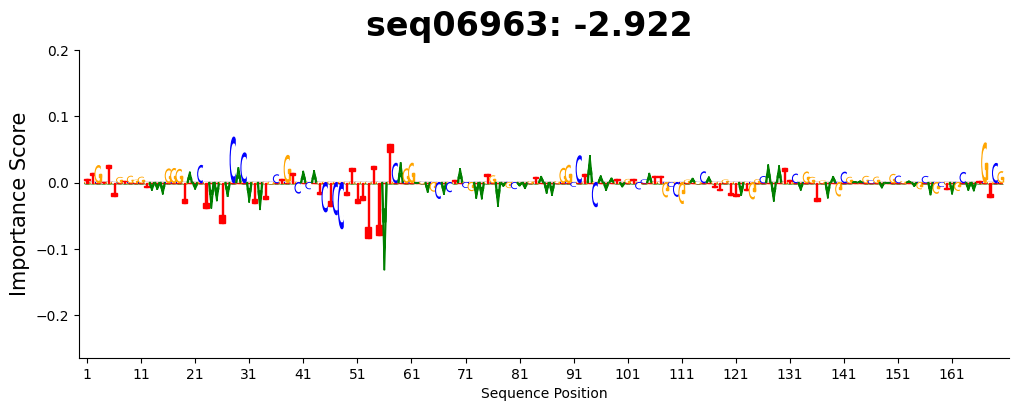

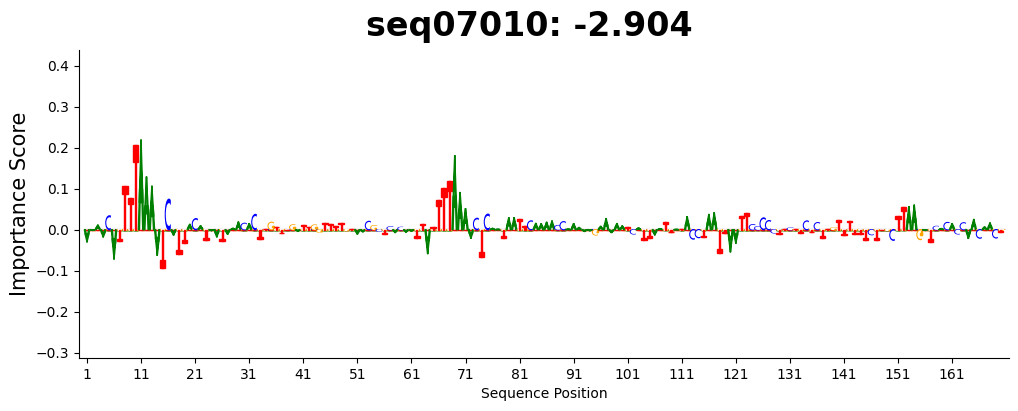

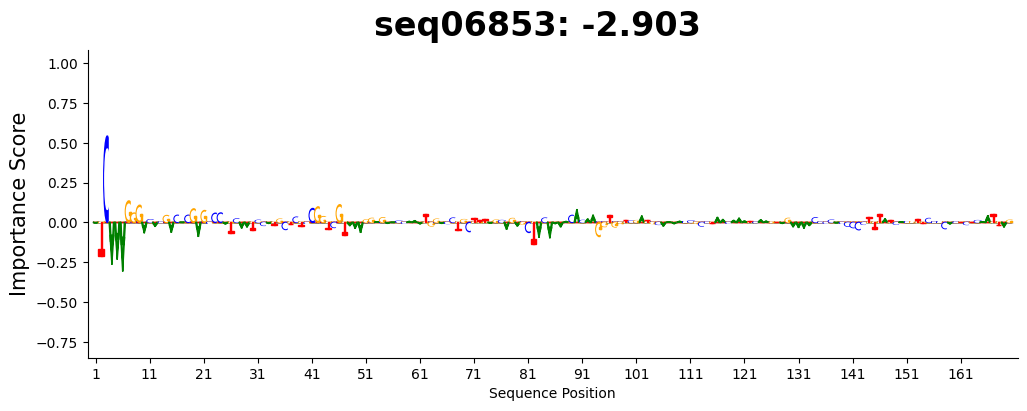

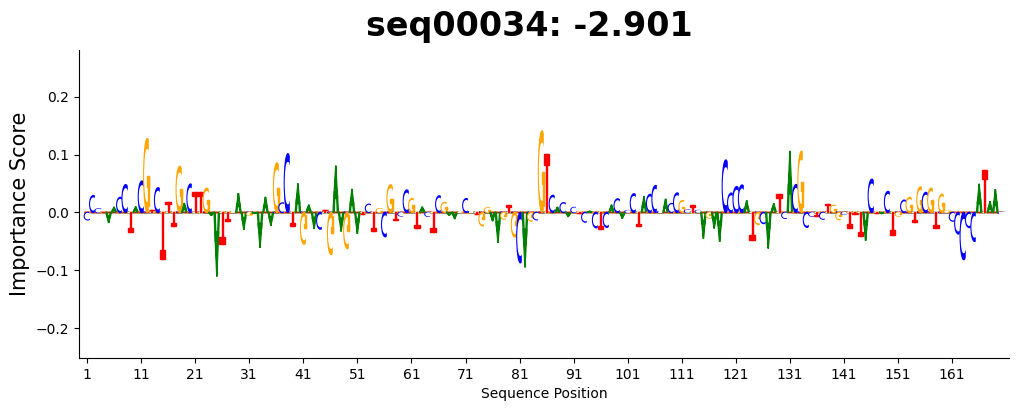

In [217]:
# Plot the top 10
for seq in highest_10_leaf:
    eu.pl.seq_track(
        sdata_leaf_test,
        seq_id=seq,
        uns_key="DeepLift_imps",
        pred_key="enrichment_predictions",
        save=f"/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/leaf_{seq}_track_Jores21CNN_leaf_v{leaf_version-1}.png"
    )

# Plot the bottom 10
for seq in lowest_10_leaf:
    eu.pl.seq_track(
        sdata_leaf_test,
        seq_id=seq,
        uns_key="DeepLift_imps",
        pred_key="enrichment_predictions",
        save=f"/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/leaf_{seq}_track_Jores21CNN_leaf_v{leaf_version-1}.png"
    )

In [218]:
# Get per nucleotide feature attibutions
eu.interpret.feature_attribution(
    best_model_proto,
    sdata_proto_test,
    saliency_method="DeepLift",
    device= "cuda" if eu.settings.gpus > 0 else "cpu"
)

# Grab the top and bottom 10 to start
highest_10_proto = sdata_proto_test["enrichment_predictions"].sort_values(ascending=False).head(10).index
lowest_10_proto = sdata_proto_test["enrichment_predictions"].sort_values(ascending=True).head(10).index

No transforms given, assuming just need to tensorize).


Computing saliency on batches:   0%|          | 0/59 [00:00<?, ?it/s]

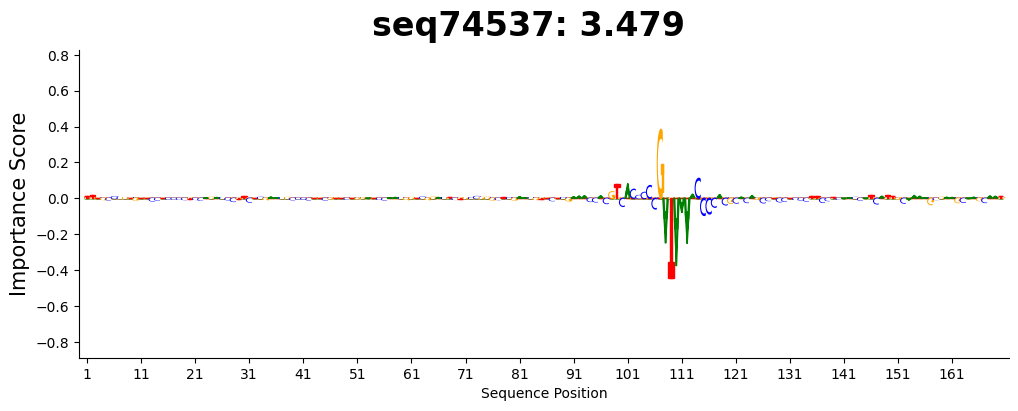

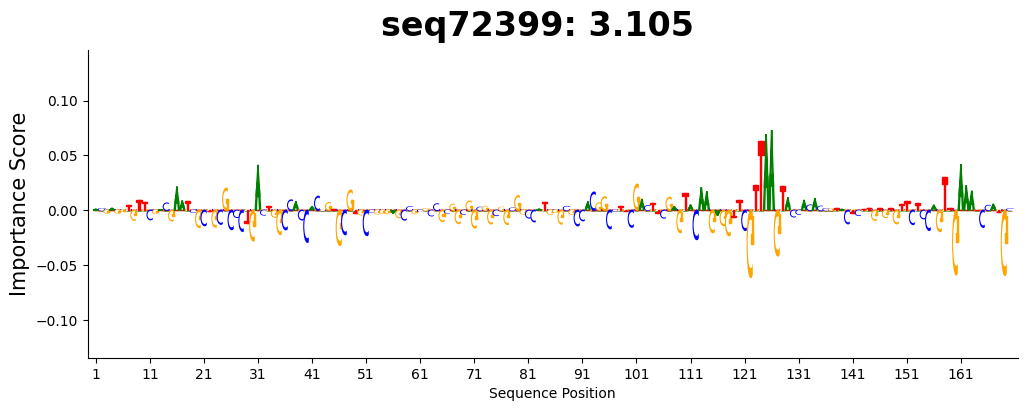

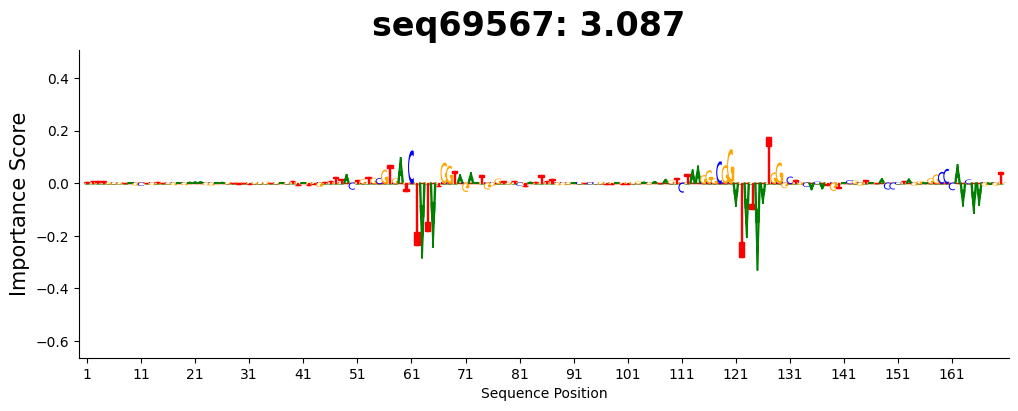

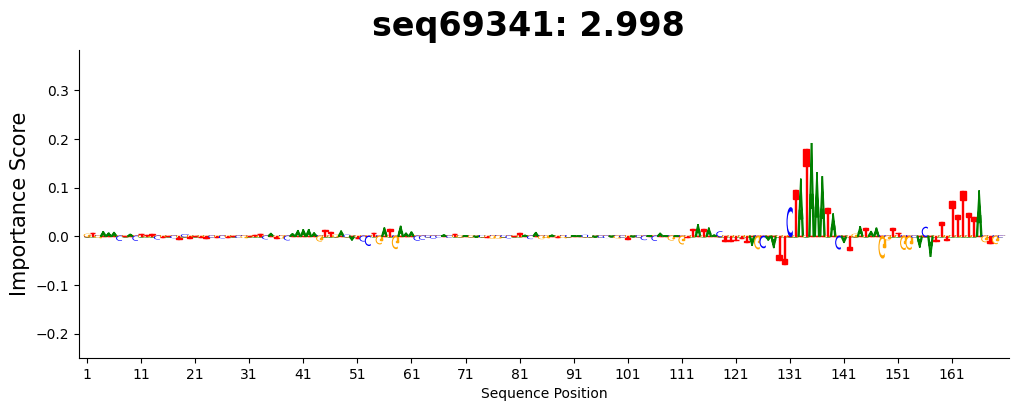

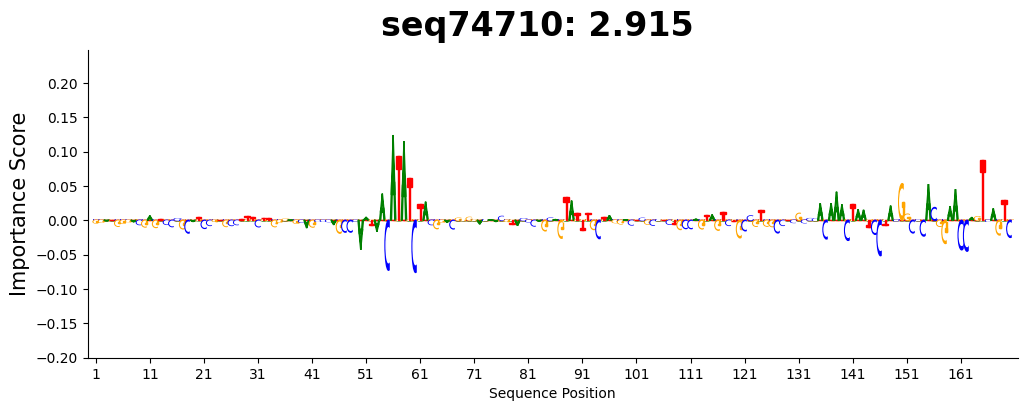

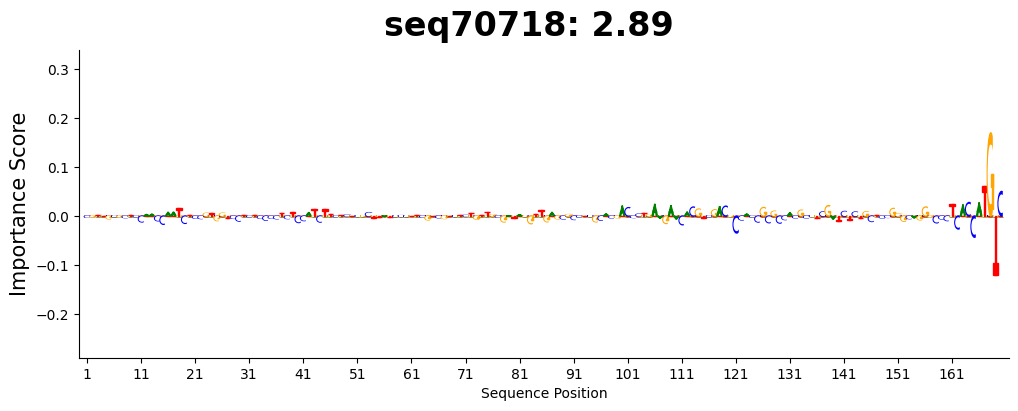

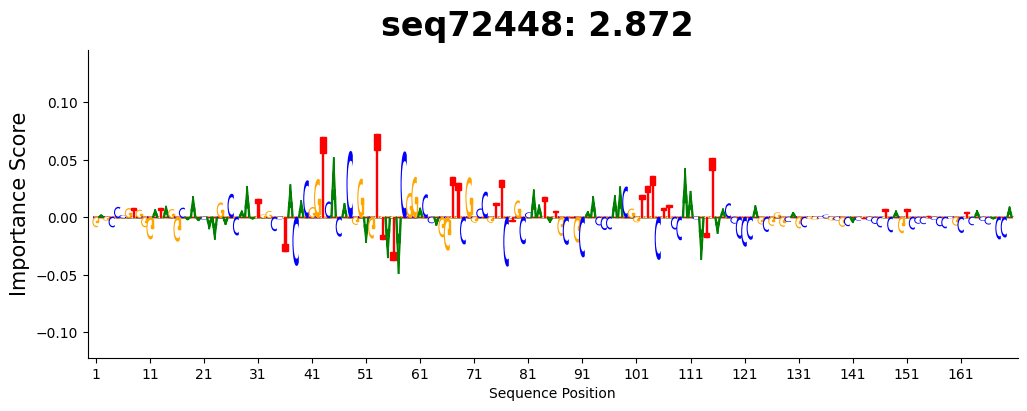

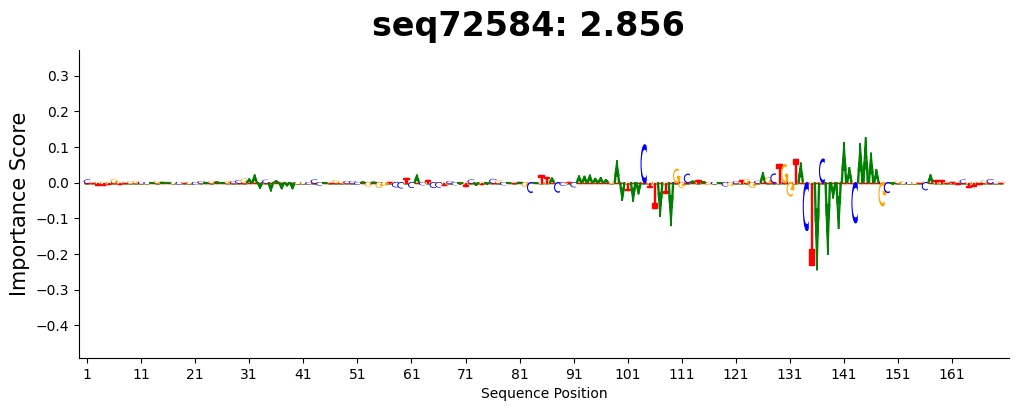

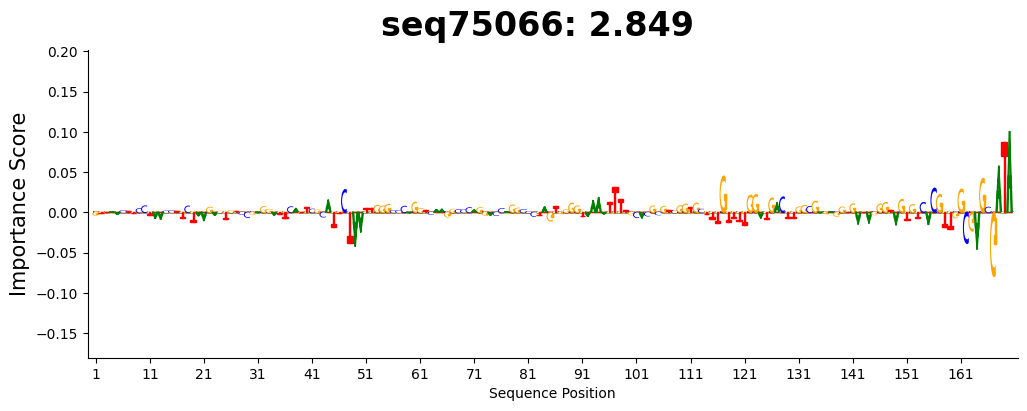

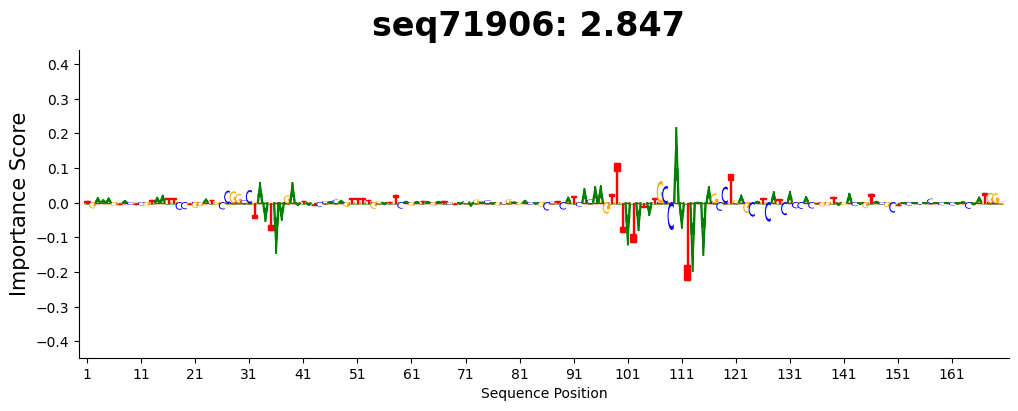

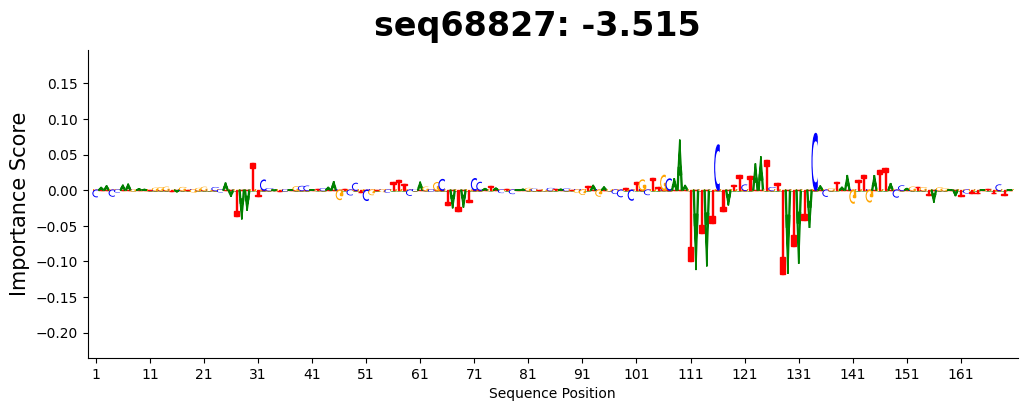

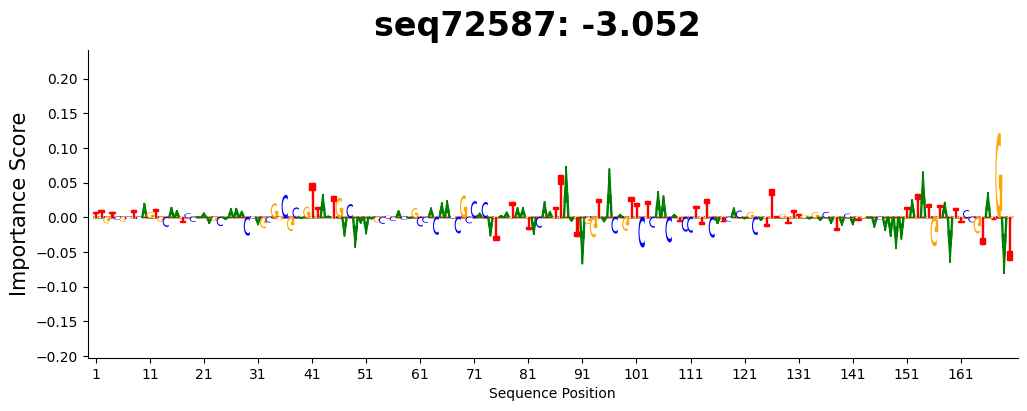

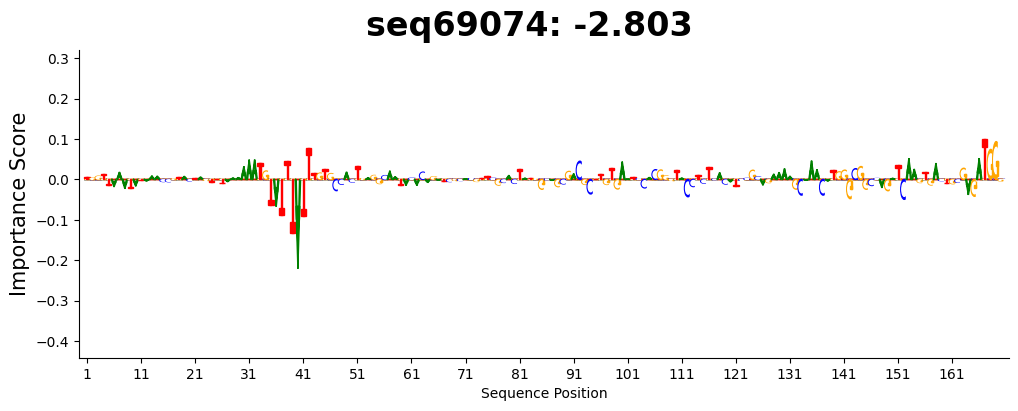

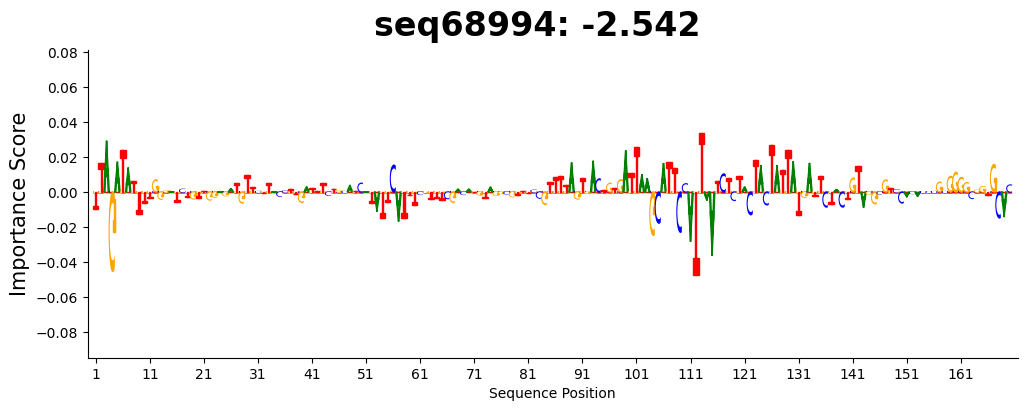

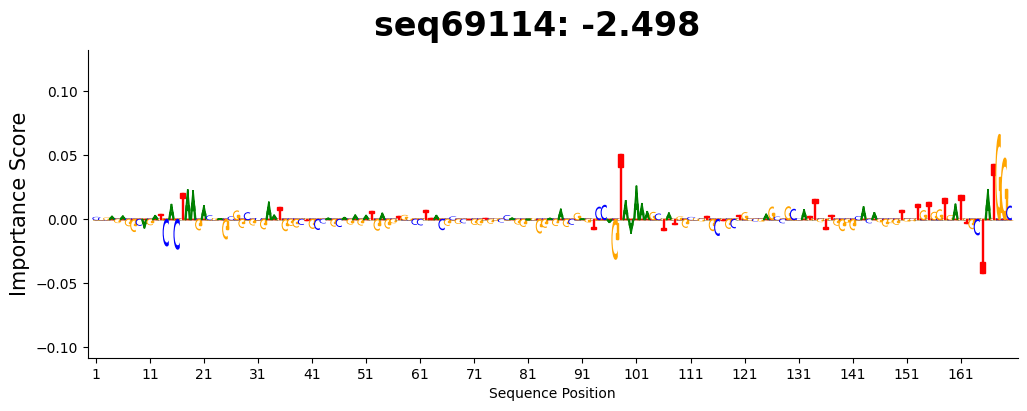

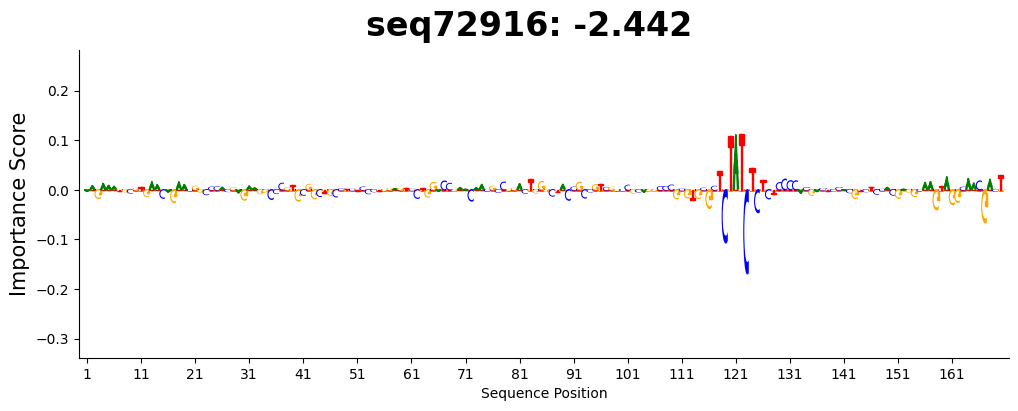

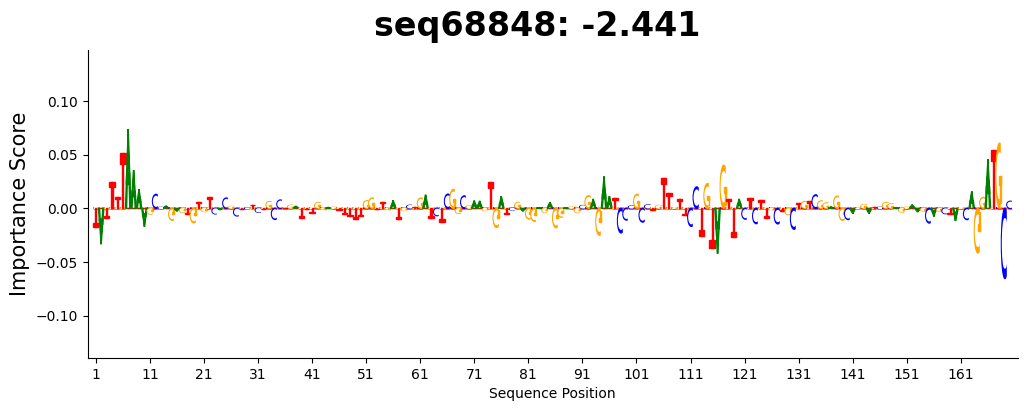

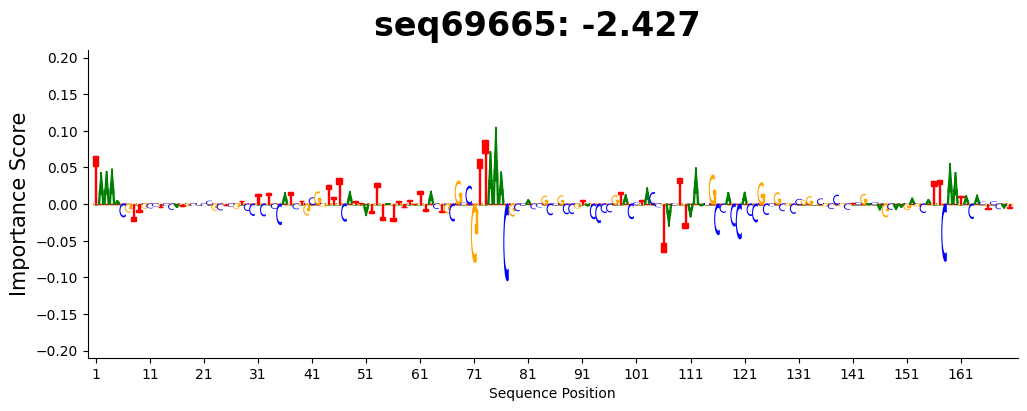

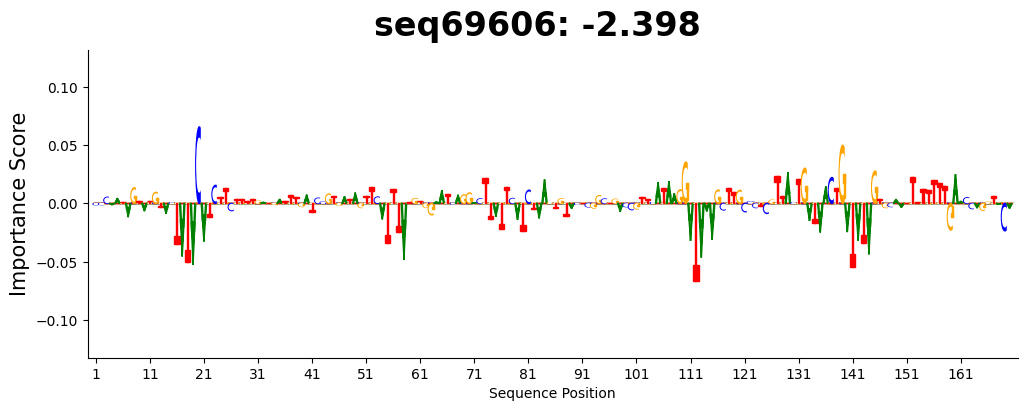

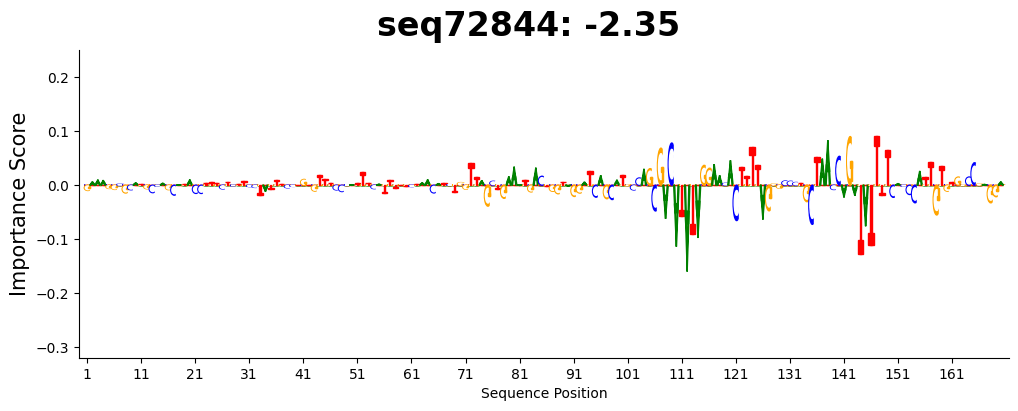

In [219]:
# Plot the top 10
for seq in highest_10_proto:
    eu.pl.seq_track(
        sdata_proto_test,
        seq_id=seq,
        uns_key="DeepLift_imps",
        pred_key="enrichment_predictions",
        save=f"/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/proto_{seq}_track_Jores21CNN_proto_v{proto_version-1}.png"
    )
# Plot the bottom 10
for seq in lowest_10_proto:
    eu.pl.seq_track(
        sdata_proto_test,
        seq_id=seq,
        uns_key="DeepLift_imps",
        pred_key="enrichment_predictions",
        save=f"/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/proto_{seq}_track_Jores21CNN_proto_v{proto_version-1}.png"
    )

In [220]:
# Calculate the PCA on the importance vector
eu.interpret.pca(
    sdata_leaf_test,
    uns_key="DeepLift_imps",
)
eu.interpret.pca(
    sdata_proto_test,
    uns_key="DeepLift_imps",
)

Make sure your matrix is sample by feature
Make sure your matrix is sample by feature


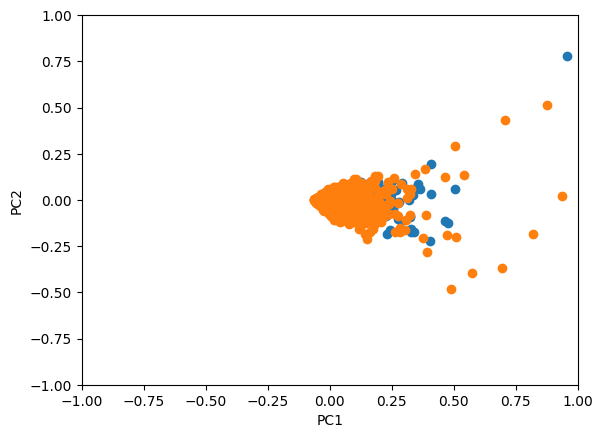

In [221]:
# Plot the resulting PCA
eu.pl.pca(
    sdata_leaf_test,
    seqsm_key="DeepLift_imps_pca",
)
eu.pl.pca(
    sdata_proto_test,
    seqsm_key="DeepLift_imps_pca",
)

In [222]:
# Calculate the UMAP on the importance vector
eu.interpret.umap(
    sdata_leaf_test,
    uns_key="DeepLift_imps",
)
eu.interpret.umap(
    sdata_proto_test,
    uns_key="DeepLift_imps",
)

Make sure your matrix is sample by feature
Make sure your matrix is sample by feature


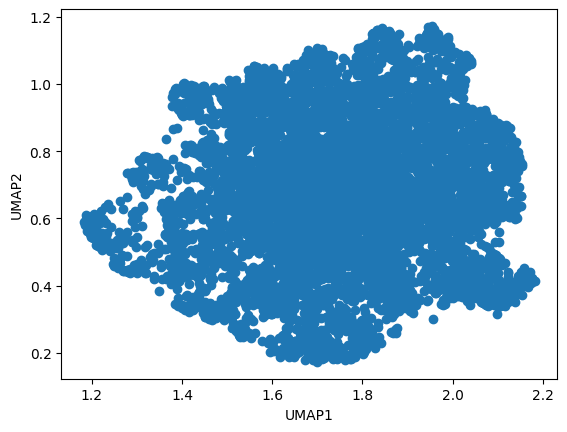

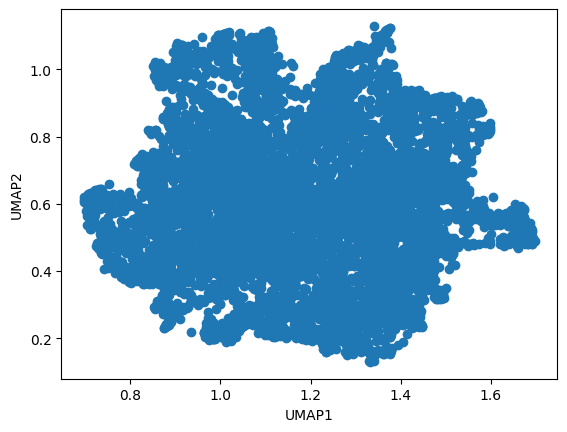

In [223]:
# Plot the resulting UMAP
eu.pl.umap(
    sdata_leaf_test,
    seqsm_key="DeepLift_imps_umap"
)
eu.pl.umap(
    sdata_proto_test,
    seqsm_key="DeepLift_imps_umap"
)

In [224]:
# Add in filter visualization
eu.interpret.generate_pfms(
    best_model_leaf, 
    sdata_leaf_test
)
eu.interpret.generate_pfms(
    best_model_proto,
    sdata_proto_test
)

No transforms given, assuming just need to tensorize).


Getting maximial activating seqlets:   0%|          | 0/55 [00:00<?, ?it/s]

Getting PFMs from filters:   0%|          | 0/256 [00:00<?, ?it/s]

No transforms given, assuming just need to tensorize).


Getting maximial activating seqlets:   0%|          | 0/59 [00:00<?, ?it/s]

Getting PFMs from filters:   0%|          | 0/256 [00:00<?, ?it/s]

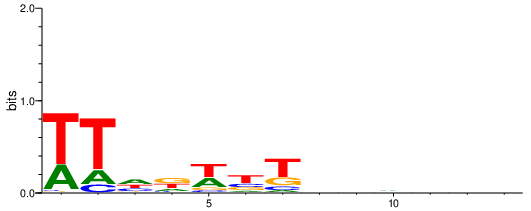

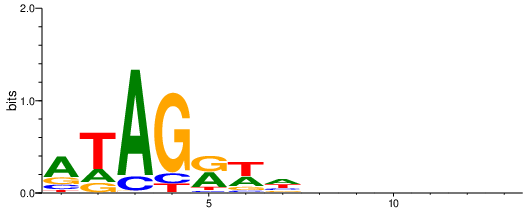

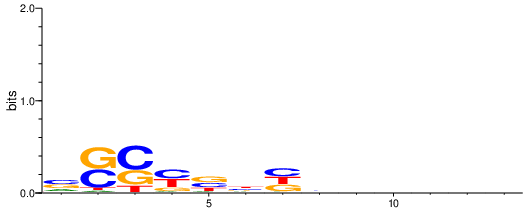

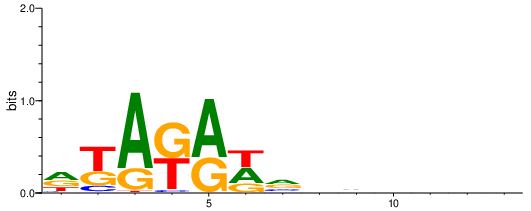

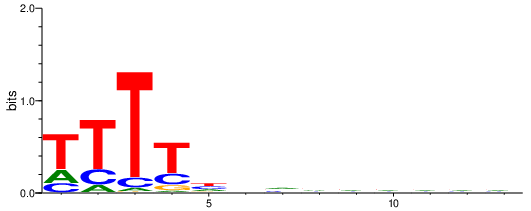

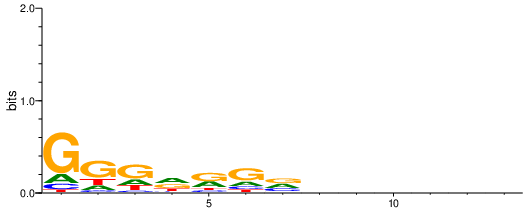

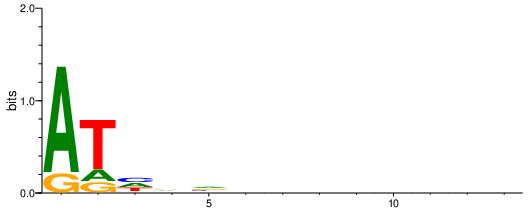

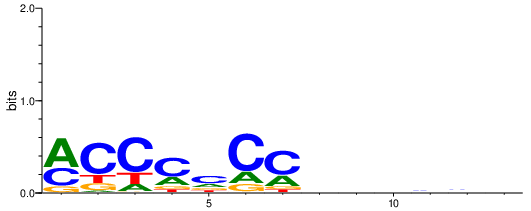

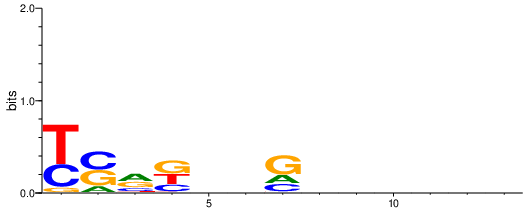

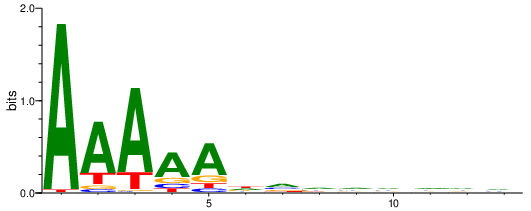

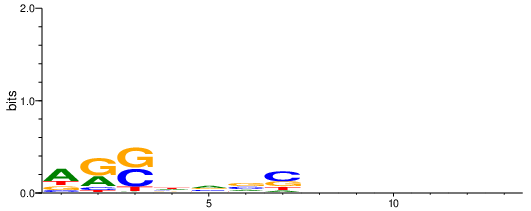

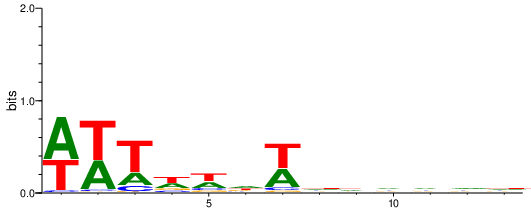

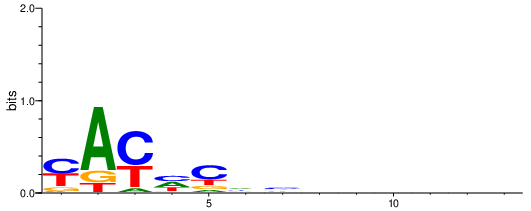

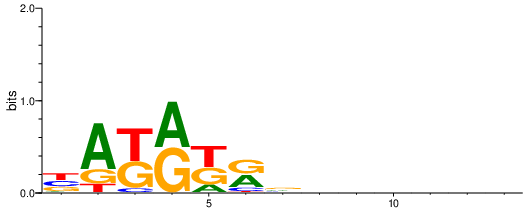

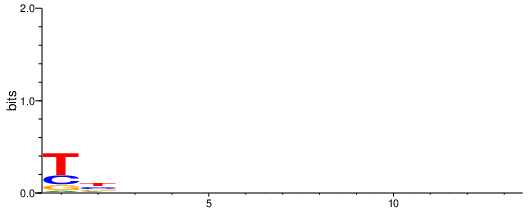

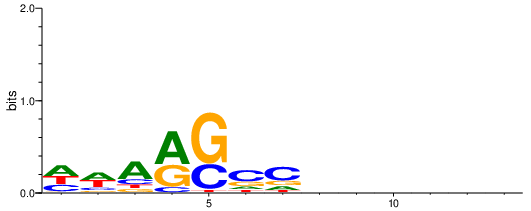

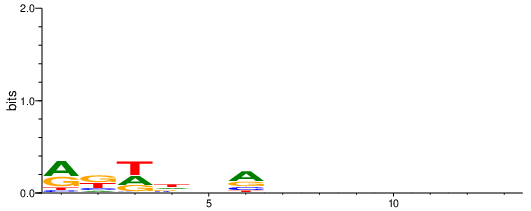

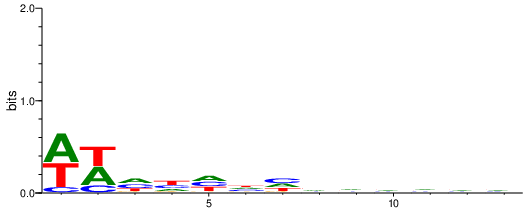

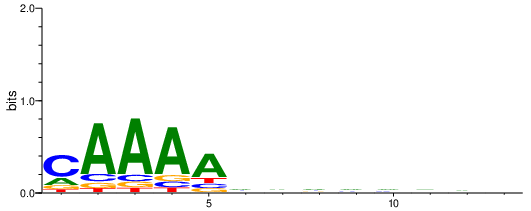

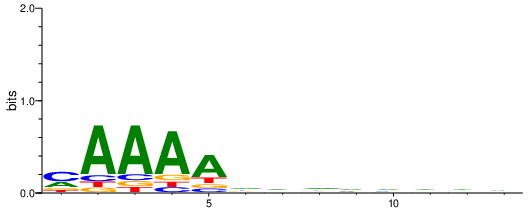

<Figure size 640x480 with 0 Axes>

In [225]:
for i in np.random.choice(np.arange(256), 10):
    eu.pl.filter_viz(
        sdata_leaf_test, 
        filter_id=i,
        save=f"/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/leaf_filter_{i}_Jores21CNN_leaf_v{leaf_version-1}.png"
    )
    eu.pl.filter_viz(
        sdata_proto_test,
        filter_id=i,
        save=f"/cellar/users/aklie/projects/EUGENe/EUGENe_paper/output/jores21/proto_filter_{i}_Jores21CNN_proto_v{proto_version-1}.png"
    )


In [8]:
eu.interpret.

Jores21CNN(
  (hp_metric): R2Score()
  (biconv): BiConv1D(
    (kernels): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 256x4x13]
        (1): Parameter containing: [torch.FloatTensor of size 256x256x13]
        (2): Parameter containing: [torch.FloatTensor of size 256x256x13]
    )
    (biases): ParameterList(
        (0): Parameter containing: [torch.FloatTensor of size 256]
        (1): Parameter containing: [torch.FloatTensor of size 256]
        (2): Parameter containing: [torch.FloatTensor of size 256]
    )
  )
  (conv): Conv1d(256, 256, kernel_size=(13,), stride=(1,), padding=same)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=43520, out_features=64, bias=True)
  (batchnorm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

---

# Scratch

In [ ]:
model(torch.Tensor(sdata_leaf_train.ohe_seqs[:10]).transpose(1,2))

RuntimeError: Given groups=1, weight of size [128, 4, 13], expected input[10, 170, 4] to have 4 channels, but got 170 channels instead

In [ ]:
import torch.nn.functional as F

In [ ]:
input = torch.Tensor(sdata_leaf_train.ohe_seqs[:10]).transpose(1,2)

In [ ]:
model.biconv.kernels[0].shape

torch.Size([128, 4, 13])

In [ ]:
input.shape

torch.Size([10, 4, 170])

In [ ]:
F.conv1d(torch.Tensor(sdata_leaf_train.ohe_seqs[:10]).transpose(1,2), model.biconv.kernels[0], stride=1, padding="same").shape

torch.Size([10, 128, 170])

In [ ]:
model.biconv.kernels[0]

Parameter containing:
tensor([[[ 1.8247e-02,  2.1020e-02, -5.2288e-03,  ...,  2.9558e-02,
           3.6861e-03, -4.6711e-02],
         [-7.6225e-03,  9.1718e-03, -5.8189e-03,  ..., -3.1849e-02,
          -8.0513e-03,  1.0549e-02],
         [-3.4858e-02,  9.5072e-03,  2.4341e-02,  ..., -2.8186e-02,
          -2.8960e-02, -1.4940e-02],
         [-5.3799e-02, -4.2594e-02, -5.7693e-02,  ..., -3.3080e-02,
           5.5993e-03, -2.2496e-02]],

        [[-4.3587e-02,  1.8178e-02,  3.6548e-02,  ..., -1.9456e-02,
          -4.3276e-02,  8.7826e-03],
         [-3.0196e-02,  4.5119e-02, -1.1855e-02,  ...,  1.4869e-02,
          -1.1759e-02,  5.4032e-02],
         [-5.4476e-02, -5.5488e-02, -3.5226e-02,  ...,  1.0950e-03,
          -1.3722e-02,  5.5493e-02],
         [-4.1682e-02, -4.0227e-02,  3.1745e-02,  ...,  5.1595e-03,
          -3.2671e-02,  2.4946e-02]],

        [[-5.4712e-02,  4.9778e-02, -7.6034e-03,  ..., -5.3725e-02,
           3.7057e-02, -2.0901e-02],
         [-5.3655e-02,  4.482

In [ ]:
model.biconv.kernels[0].shape

torch.Size([128, 4, 13])

In [ ]:
all_motifs

{'TATA': Motif(identifier='TATA', pfm=array([[0.1275, 0.3765, 0.1195, 0.3765],
        [0.1575, 0.3985, 0.199 , 0.2455],
        [0.249 , 0.303 , 0.197 , 0.251 ],
        [0.1235, 0.655 , 0.0755, 0.1455],
        [0.01  , 0.002 , 0.002 , 0.986 ],
        [0.968 , 0.    , 0.    , 0.032 ],
        [0.002 , 0.014 , 0.006 , 0.978 ],
        [0.992 , 0.    , 0.002 , 0.006 ],
        [0.653 , 0.012 , 0.002 , 0.333 ],
        [0.974 , 0.    , 0.008 , 0.018 ],
        [0.341 , 0.028 , 0.036 , 0.5955],
        [0.6955, 0.0815, 0.1195, 0.1035],
        [0.1255, 0.432 , 0.3165, 0.1255],
        [0.291 , 0.418 , 0.175 , 0.1155],
        [0.263 , 0.3445, 0.1755, 0.2175],
        [0.307 , 0.3085, 0.2365, 0.1475]]), alphabet_length=4, length=16, name='TATA', source_sites=256, source_evalue=0.0),
 'Inr': Motif(identifier='Inr', pfm=array([[0.131 , 0.467 , 0.14  , 0.262 ],
        [0.168 , 0.346 , 0.093 , 0.393 ],
        [0.41  , 0.23  , 0.075 , 0.285 ],
        [0.238 , 0.2895, 0.1265, 0.3455],
     

In [ ]:
model.biconv.kernels[0][0].transpose(0, 1)

tensor([[0.5100, 1.5060, 0.4780, 1.5060],
        [0.6300, 1.5940, 0.7960, 0.9820],
        [0.9960, 1.2120, 0.7880, 1.0040],
        [0.4940, 2.6200, 0.3020, 0.5820],
        [0.0400, 0.0080, 0.0080, 3.9440],
        [3.8720, 0.0000, 0.0000, 0.1280],
        [0.0080, 0.0560, 0.0240, 3.9120],
        [3.9680, 0.0000, 0.0080, 0.0240],
        [2.6120, 0.0480, 0.0080, 1.3320],
        [3.8960, 0.0000, 0.0320, 0.0720],
        [1.3640, 0.1120, 0.1440, 2.3820],
        [2.7820, 0.3260, 0.4780, 0.4140],
        [0.5020, 1.7280, 1.2660, 0.5020]], grad_fn=<TransposeBackward0>)

In [ ]:
torch.flip(model.biconv.kernels[0], dims=[1, 2])[0].transpose(0, 1)

tensor([[0.5020, 1.2660, 1.7280, 0.5020],
        [0.4140, 0.4780, 0.3260, 2.7820],
        [2.3820, 0.1440, 0.1120, 1.3640],
        [0.0720, 0.0320, 0.0000, 3.8960],
        [1.3320, 0.0080, 0.0480, 2.6120],
        [0.0240, 0.0080, 0.0000, 3.9680],
        [3.9120, 0.0240, 0.0560, 0.0080],
        [0.1280, 0.0000, 0.0000, 3.8720],
        [3.9440, 0.0080, 0.0080, 0.0400],
        [0.5820, 0.3020, 2.6200, 0.4940],
        [1.0040, 0.7880, 1.2120, 0.9960],
        [0.9820, 0.7960, 1.5940, 0.6300],
        [1.5060, 0.4780, 1.5060, 0.5100]], grad_fn=<TransposeBackward0>)